In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [2]:
# Importar funciones importantes de grafos de mi autoria
from funciones_grafos import *

## Clasificacion Binaria (conectividad grafo 20x20) con Pytorch Geometric

#### Hyper parameters

In [3]:
# que porcentaje de los 1000000 datos se van a usar
porcentaje_datos = 0.2
# que porcentaje de los datos a utilizar es de entrenamiento
tr_r = 0.5
# tamaño de un batch
batch_s = 1280
# learning rate
lr = 0.005
# numero de epocas a entrenar
num_epochs = 30

### Funcion para crear un dataset

In [4]:
class create_pytorchGeometric_dataset(Dataset):
    
    def __init__(self, name_datos_graphs, name_datos_labels, porcentaje = 1):
        super().__init__()
        
        # obtener la ruta completa de los archivos
        file_path_datos_graphs = '.\\datos\\' + name_datos_graphs + '.npy'
        file_path_datos_labels = '.\\datos\\' + name_datos_labels + '.npy'
        # cargar los datos
        self.datos_grafos = np.load(file_path_datos_graphs)
        self.datos_labels = np.load(file_path_datos_labels)
        
        # solo tomar un porcentaje de los datos, delimitar la longuitud del dataset
        self.cantidad = len(self.datos_labels)
        self.datos_grafos = self.datos_grafos[:int(porcentaje * self.cantidad)]
        self.datos_labels = self.datos_labels[:int(porcentaje * self.cantidad)]
        self.cantidad = len(self.datos_labels)
        
    # longuitud del dataset
    def len(self):
        return self.cantidad

    # obtener un elemento, asociado con el indice idx
    # esto consiste en un objeto data, que representa un grafo y su label
    def get(self, idx):
        # como  no se tienen node-features, se usa la matriz identidad
        # recordar que tenemos grafos 20x20
        x = np.eye(20)
        x = torch.from_numpy(x).float()
        
        # tomar el vector del grafo en cuestion
        vector = self.datos_grafos[idx]
        # crear el edge_index y hacerlo un tensor
        edge_index = vector_to_edge_index(vector)
        edge_index = torch.from_numpy(edge_index)
        
        # tomar el label del grafo y hacerlo tensor
        y = self.datos_labels[idx]
        y = torch.tensor([y]).long()
        
        # crear el objeto data y devolverlo
        return Data(x=x, edge_index=edge_index, y=y)

### Crear el dataset

Haciendo uso de los datos creados en "Crear_Datos.IPYNB"

In [5]:
file_X = 'datos_edros_N1000000_n20_multiple_p'
file_y =  'datos_edros_N1000000_n20_multiple_p_etiqueta_conectividad'
dataset = create_pytorchGeometric_dataset(file_X, file_y, porcentaje_datos)

### Ver un poco el dataset

In [6]:
numero_grafos = len(dataset)
print(f'Number of graphs: {numero_grafos}')
num_c = dataset.num_classes
print(f'Number of classes: {num_c}')

Number of graphs: 200000
Number of classes: 2


In [7]:
# Gather some statistics about the first graph.
data = dataset[0]  # Get the first graph object.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[20, 20], edge_index=[2, 40], y=[1])
Number of nodes: 20
Number of edges: 40
Average node degree: 2.00
Has isolated nodes: True
Has self-loops: False
Is undirected: True


### Dividir en entrenamiento y prueba

In [8]:
# proporciones de entrenamiento y test
train_ratio = tr_r
division_train_test = int(numero_grafos * train_ratio)

train_dataset = dataset[:division_train_test]
test_dataset = dataset[division_train_test:]

In [9]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 100000
Number of test graphs: 100000


### Hacer los Data Loaders

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)

### Crear Modelo

In [11]:
# Modelo de GCN para clasificacion de grafos

class GCN(torch.nn.Module):
    
    def __init__(self, input_size, hidden, n_classes):
        super(GCN, self).__init__()
        
        self.conv1 = GCNConv(input_size, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        
        self.lin = Linear(hidden, n_classes)
        self.final_activation = nn.Softmax(dim=1)

    def forward(self, x, edge_index, batch):
        # Obtener representaciones vectoriales de los nodos
        x = self.conv1(x, edge_index)    # primera capa:            Input (20)     ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv2(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv3(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        # Obtener representacion vectorial del grafo 
        x = global_mean_pool(x, batch)  # pooling                   Mean pool  
        # Clasificador final
        x = self.lin(x)                 # clasificador:             hidden_channels ----> n_classes (2)
        x = self.final_activation(x)    # funcion de activacion:    SoftMax 
        
        return x

In [12]:
# Instanciar el modelo
model = GCN(input_size = 20, hidden=20, n_classes = 2)
model

GCN(
  (conv1): GCNConv(20, 20)
  (conv2): GCNConv(20, 20)
  (conv3): GCNConv(20, 20)
  (lin): Linear(in_features=20, out_features=2, bias=True)
  (final_activation): Softmax(dim=1)
)

### Enternamiento

In [13]:
# parametros entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()

Funcion de entrenamiento (un epoch)

In [14]:
def train():
    
    # poner el modelo en modo de entrenamiento
    model.train()
    
    # pasar los batches nescesarios para terminar un epoch en el training set
    for data in train_loader: 
        # Obtener las predicciones
        out = model(data.x, data.edge_index, data.batch)
        # Calcular la funcion de perdida
        loss = loss_function(out, data.y)
        # Hacer backpropagation y actualizar los pesos
        loss.backward()           # Derive gradients.
        optimizer.step()          # Update parameters based on gradients.
        optimizer.zero_grad()     # Clear gradients.

Funcion para obtener el el loss en un loader

In [15]:
def compute_loss(loader):
    # se da como argumento un data loader, se evalua la perdida en este
    
    # poner el modelo en modo de evaluar
    model.eval()

    # perdida total
    total_loss = 0
    # numero de samples
    total_samples = 0
    
    # pasar los bathces que tiene el loader
    with torch.no_grad():
        for data in loader:
            # Obtener las predicciones
            out = model(data.x, data.edge_index, data.batch)

            n_samples = data.y.shape[0]
            # Calcular la perdida total: MSE * num_samples
            total_loss += loss_function(out, data.y).item() * n_samples
            total_samples += n_samples

    # Devolver la funcion de costo promedio
    return total_loss/total_samples

Funcion para evaluar la presicion

In [16]:
def compute_acc(loader):
    # se da como argumento un data loader, se evalua la presicion en este
    
    # poner el modelo en modo de evaluar
    model.eval()

    # predicciones correctas
    correct = 0
    
    # pasar los bathces que tiene el loader
    with torch.no_grad():
        for data in loader: 
            # prediccion (recordar que son 2 numeros, probabilidades)
            out = model(data.x, data.edge_index, data.batch)  
            # usar la clase con mas probabilidad
            pred = out.argmax(dim=1) 
            # ver cuantas prediccioens de clases fueron correctas
            correct += int((pred == data.y).sum()) 
    
    # ver la presicion: correctas/totales
    acc = correct / len(loader.dataset)
    
    return acc

Realizar entrenamiento

In [17]:
# datos a guardar en entrenamiento
hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [18]:
print('Entrenando en',train_loader.dataset.__len__() , 'datos')
print('Evaluando en',test_loader.dataset.__len__() , 'datos')
print('------------------------------------------')

# iterar en las epoch
for epoch in range(num_epochs):
    # entrenar
    train()
    
    # obtener loss en train y test
    training_loss = compute_loss(train_loader)
    testing_loss = compute_loss(test_loader)
    # obtener presiciones en train y test
    training_acc = compute_acc(train_loader)
    testing_acc = compute_acc(test_loader)
    
    # guardarlas
    hist_train_loss += [training_loss]
    hist_test_loss += [testing_loss]
    hist_train_acc += [training_acc]
    hist_test_acc += [testing_acc]
    
    # Imprimir reporte
    print(f'Epoch:[{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Test Loss: {testing_loss:.4f}, Train Acc: {training_acc:.4f}, Test Acc: {testing_acc:.4f} ')

Entrenando en 100000 datos
Evaluando en 100000 datos
------------------------------------------
Epoch:[1/30], Train Loss: 0.3649, Test Loss: 0.3649, Train Acc: 0.9486, Test Acc: 0.9480 
Epoch:[2/30], Train Loss: 0.3272, Test Loss: 0.3273, Train Acc: 0.9927, Test Acc: 0.9927 
Epoch:[3/30], Train Loss: 0.3195, Test Loss: 0.3196, Train Acc: 0.9948, Test Acc: 0.9947 
Epoch:[4/30], Train Loss: 0.3184, Test Loss: 0.3185, Train Acc: 0.9954, Test Acc: 0.9952 
Epoch:[5/30], Train Loss: 0.3179, Test Loss: 0.3180, Train Acc: 0.9954, Test Acc: 0.9955 
Epoch:[6/30], Train Loss: 0.3175, Test Loss: 0.3176, Train Acc: 0.9958, Test Acc: 0.9957 
Epoch:[7/30], Train Loss: 0.3170, Test Loss: 0.3173, Train Acc: 0.9966, Test Acc: 0.9961 
Epoch:[8/30], Train Loss: 0.3171, Test Loss: 0.3173, Train Acc: 0.9963, Test Acc: 0.9960 
Epoch:[9/30], Train Loss: 0.3165, Test Loss: 0.3168, Train Acc: 0.9970, Test Acc: 0.9966 
Epoch:[10/30], Train Loss: 0.3168, Test Loss: 0.3170, Train Acc: 0.9965, Test Acc: 0.9962 
Epo

In [19]:
# guardar las metricas de entrenamiento

hist_train_loss = np.array(hist_train_loss)
np.save('.\historiales\pytorchGeom_class_loss_train', hist_train_loss)
hist_test_loss = np.array(hist_test_loss)
np.save('.\historiales\pytorchGeom_class_loss_test', hist_test_loss)

hist_train_acc = np.array(hist_train_acc)
np.save('.\historiales\pytorchGeom_class_acc_train', hist_train_acc)
hist_test_acc = np.array(hist_test_acc)
np.save('.\historiales\pytorchGeom_class_acc_test', hist_test_acc)

Graficar entrenamiento

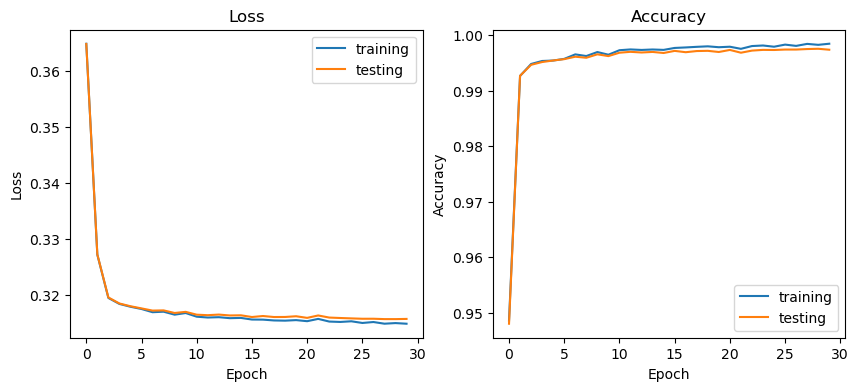

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(hist_train_loss, label = 'training')
ax1.plot(hist_test_loss, label = 'testing')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(hist_train_acc, label = 'training')
ax2.plot(hist_test_acc, label = 'testing')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

### Guardar modelo

In [24]:
ruta_archivo = '.\modelos\pytorch_geometric_conectividad_model1.pth'
#torch.save(model.state_dict(), ruta_archivo)

Cargar el modelo

In [22]:
#model_new = GCN(input_size = 20, hidden=20, n_classes = 2)
#model_new.load_state_dict(torch.load(ruta_archivo))